In [ ]:
#Created by Tsering Jorgais

In [1]:
!nvidia-smi

Thu Jul 13 20:51:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:

!pip install ultralytics==8.0.20

In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

In [5]:
!pip install tensorboardX

In [7]:
!wget -q https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
!tar xf ShelfImages.tar.gz

In [8]:
!wget -q https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz
!tar xf GroceryDataset_part2.tar.gz

In [9]:
!ls -lh ShelfImages | head -10
!ls -lh ShelfImages/train | head -10
!ls -lh ShelfImages/test | head -10

total 16K
drwxrwxr-x 2 1001 1001 4.0K Jul 13 17:28 test
drwxrwxr-x 2 1001 1001  12K Jul 13 17:28 train
total 456M
-rw-r--r-- 1 1001 1001  645K Oct 23  2019 C1_P01_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N1_S2_2.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001  870K Oct 23  2019 C1_P01_N1_S3_2.JPG
-rw-r--r-- 1 1001 1001  907K Oct 23  2019 C1_P01_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001  1.3M Oct 23  2019 C1_P01_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N2_S4_1.JPG
-rw-r--r-- 1 1001 1001  2.0M Oct 23  2019 C1_P01_N3_S2_1.JPG
total 101M
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P02_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001 1.3M Oct 23  2019 C1_P03_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P03_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001 2.4

In [10]:
from imutils import paths
from typing import List
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import torch

print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


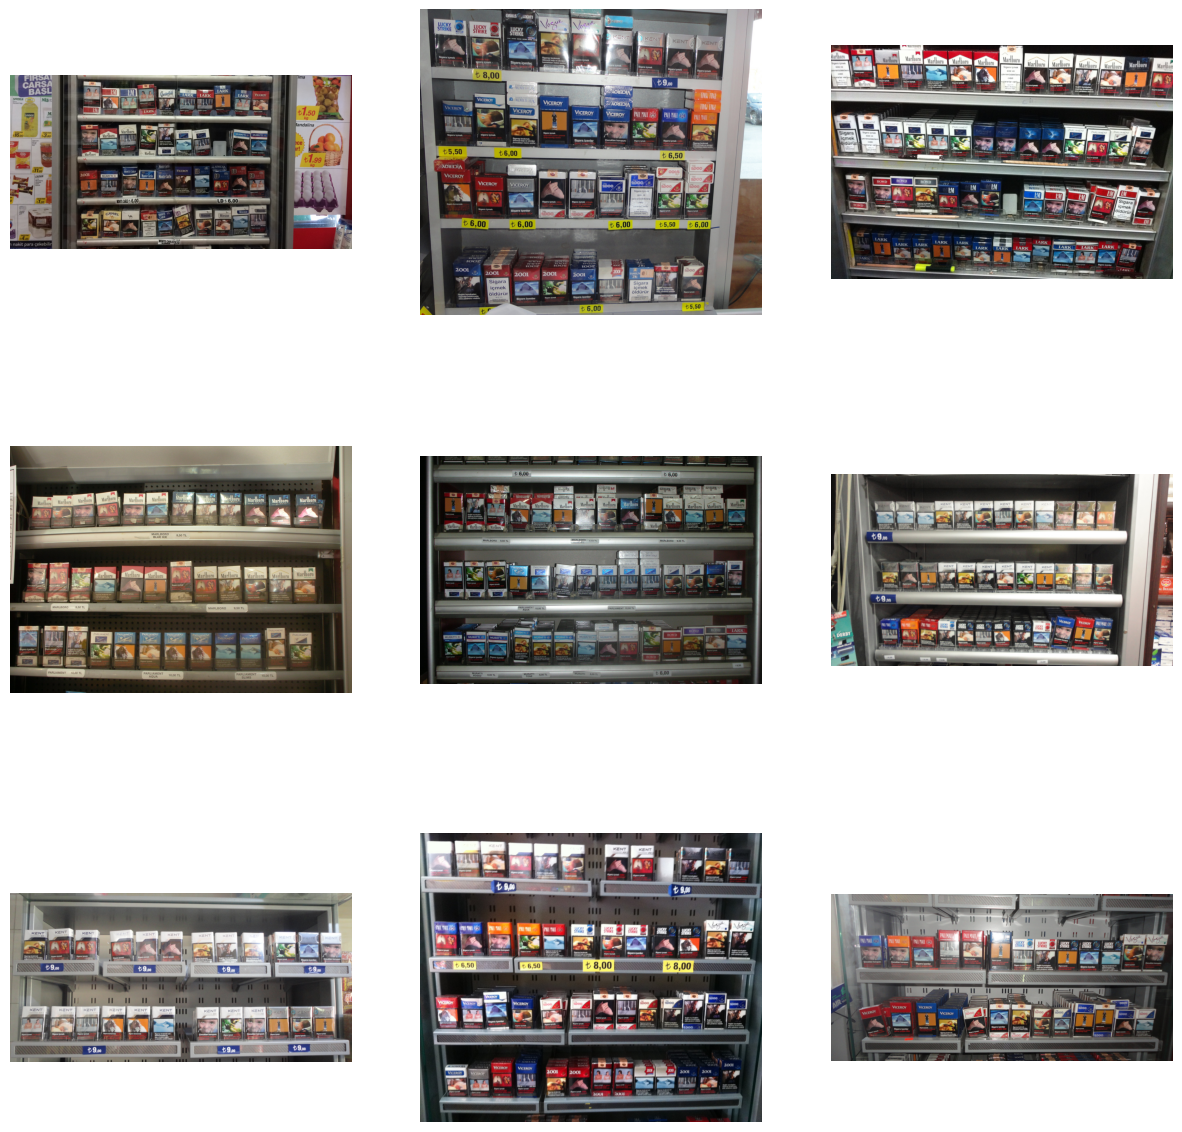

In [11]:
train_images = list(paths.list_images("ShelfImages/train"))
plt.figure(figsize=(15, 15))
for i, image  in enumerate(train_images[:9]):
    image = plt.imread(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

In [13]:
cols = ["image_name", "x_i", "y_i", "w_i", "h_i", "b_i"]
master_df = pd.read_csv("https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv",
                        names=cols)
master_df.head()

image_name   x_i   y_i   w_i   h_i  b_i
0  C1_P01_N1_S2_1.JPG  1008  1552  1260  1928    0
1  C1_P01_N1_S2_1.JPG  1028   928  1280  1304    0
2  C1_P01_N1_S2_1.JPG    24   872   268  1264    0
3  C1_P01_N1_S2_1.JPG   280  1568   532  1944    0
4  C1_P01_N1_S2_1.JPG   292   872   544  1248    0

In [14]:
# How many unique brands? (0 stands for "other" class)
master_df["b_i"].unique()

array([ 0,  1,  4,  7,  3,  6, 10,  2,  5,  8,  9])

In [15]:
def vis_annotations(image_path: str, coordinate_list: List[List[int]],
                    color: str="blue") -> None:
    """Converts bounding box to matplotlib format, imposes it on the
    provided image and then displays the plot."""
    image = plt.imread(image_path)
    fig = plt.imshow(image)
    for i in range(len(coordinate_list)):
        bbox = coordinate_list[i]
        fig.axes.add_patch(plt.Rectangle(
            xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
            fill=False, edgecolor=color, linewidth=2))
    plt.show()

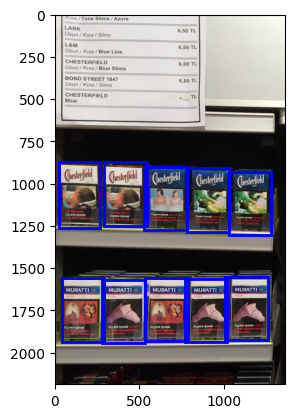

In [16]:
coordinate_columns = master_df.columns[1:-1]
coordinate_list = master_df[master_df["image_name"]=="C1_P01_N1_S2_1.JPG"][coordinate_columns]
coordinate_list = coordinate_list.values.tolist()
vis_annotations("ShelfImages/train/C1_P01_N1_S2_1.JPG", coordinate_list)

In [17]:
# Grab the image names belonging to the train and test sets
train_images = list(paths.list_images("ShelfImages/train"))
test_images = list(paths.list_images("ShelfImages/test"))
train_image_names = [image_path.split("/")[-1] for image_path in train_images]
test_image_names = [image_path.split("/")[-1] for image_path in test_images]
print(len(train_image_names), len(test_image_names))

283 71


In [18]:
# Create two different dataframes from train and test sets
train_df = master_df[master_df["image_name"].isin(train_image_names)]
test_df = master_df[~master_df["image_name"].isin(train_image_names)]
print(len(np.unique(train_df["image_name"])), len(np.unique(test_df["image_name"])))

283 71


In [19]:
# Let's turn the image names into absolute paths
train_df["image_name"] = train_df["image_name"].map(lambda x: "ShelfImages/train/" + x)
test_df["image_name"] = test_df["image_name"].map(lambda x: "ShelfImages/test/" + x)

<ipython-input-19-5339d736f7f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["image_name"] = train_df["image_name"].map(lambda x: "ShelfImages/train/" + x)
<ipython-input-19-5339d736f7f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["image_name"] = test_df["image_name"].map(lambda x: "ShelfImages/test/" + x)


In [20]:
# Preview
train_counts = len(train_df['image_name'].unique())
test_counts = len(test_df['image_name'].unique())
print(f'Total Unique train images {train_counts}')
print(f'Total Unique test images {test_counts}')

Total Unique train images 283
Total Unique test images 71


In [21]:
# it takes class label, xy, wh
def form_line(cls, x, y, w, h):
  line = str(cls)+' '+ str(x) +' '+ str(y) + ' ' + str(w) + ' ' + str(h) + '\n'
  return line

In [22]:
train_df['b_i'].unique()

array([ 0,  1,  4,  7,  3,  6, 10,  2,  5,  8,  9])

In [37]:
# fetch list of train images in the shelf images dataset
train_images = sorted(train_df['image_name'].unique())
# fetch list of test images in the shelf images dataset
test_images = sorted(test_df['image_name'].unique())

# destination train image path
dst_train_path = os.path.join('/content/Prep_data/train', 'images')
# destination test image path
dst_test_path = os.path.join('/content/Prep_data/test', 'images')
# train annotation path
annot_train = os.path.join('/content/Prep_data/train', 'labels')
# test annotation path
annot_test = os.path.join('/content/Prep_data/test', 'labels')

# prepare destination directory
if not os.path.isdir('/content/Prep_data'):
  os.mkdir('/content/Prep_data')
  # train and test path
  os.mkdir('/content/Prep_data/train')
  os.mkdir('/content/Prep_data/test')

def fetch_annotation(img_path, df):
  img_id = img_path.split('/')[-1]
  img_w, img_h = np.flip(plt.imread(img_path).shape[:2])[:2]
  lines = ''
  for record in np.array(df[df['image_name']==img_path]):
    #print(f'Image name {img_id}')
    # print(record[-1])
    class_label = record[-1]

    w = record[3] - record[1]
    h = record[4] - record[2]
    c_x = record[1] + (w/2)
    c_y = record[2] + (h/2)
    x_norm = c_x/(img_w)
    y_norm = c_y/(img_h)
    w_norm = w/img_w
    h_norm = h/img_h
    lines+= form_line(class_label, x_norm, y_norm, w_norm, h_norm)
  return img_id, lines

# create annotation files
def data_prep(annot_path, dst_img_path, img_paths, df):
  # if annotation folder not exists
  if not os.path.isdir(annot_path):
    os.mkdir(annot_path)
  # if seperate image folder not exists
  if not os.path.isdir(dst_img_path):
    os.mkdir(dst_img_path)

  for img_path in tqdm(img_paths):
    img = plt.imread(img_path)
    img_id, lines = fetch_annotation(img_path, df)
    plt.imsave(os.path.join(dst_img_path, img_id), img)

    img_name = img_id.split('.')[0]
    annot_img_file = os.path.join(annot_path, img_name)+'.txt'
    if not os.path.isfile(annot_img_file):
      with open(annot_img_file, 'x') as f:
        f.write(lines)

  assert len(os.listdir(annot_path)) == len(os.listdir(dst_img_path))
  print('\nCheck passed!')

In [38]:
# data_prep(annot_train, dst_train_path, train_images, train_df)

In [39]:
# data_prep(annot_test, dst_test_path, test_images, test_df)

In [6]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=b06bfa5cd1c5af59f878806fa3adeec7988331c39350e06a86666f79fbf0a53c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found e

In [6]:


from roboflow import Roboflow
rf = Roboflow(api_key="Add your API")
project = rf.workspace("project-6oaph").project("groceries_detection")
dataset = project.version(2).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to groceries_detection-2 in yolov8:: 100%|██████████| 1712/1712 [00:00<00:00, 1953.89it/s]


In [9]:
%cd {HOME}
#IF cause error while traning, put full path in data.yaml file for train, test and val dataset.
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=20 imgsz=800 plots=True

/content
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/groceries_detection-2/data.yaml, epochs=20, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fa

In [11]:
!ls {HOME}/runs/detect/train3/

args.yaml					    train_batch2.jpg
confusion_matrix.png				    train_batch470.jpg
events.out.tfevents.1689281658.1d3b468964eb.2889.0  train_batch471.jpg
F1_curve.png					    train_batch472.jpg
P_curve.png					    val_batch0_labels.jpg
PR_curve.png					    val_batch0_pred.jpg
R_curve.png					    val_batch1_labels.jpg
results.csv					    val_batch1_pred.jpg
results.png					    val_batch2_labels.jpg
train_batch0.jpg				    val_batch2_pred.jpg
train_batch1.jpg				    weights


/content


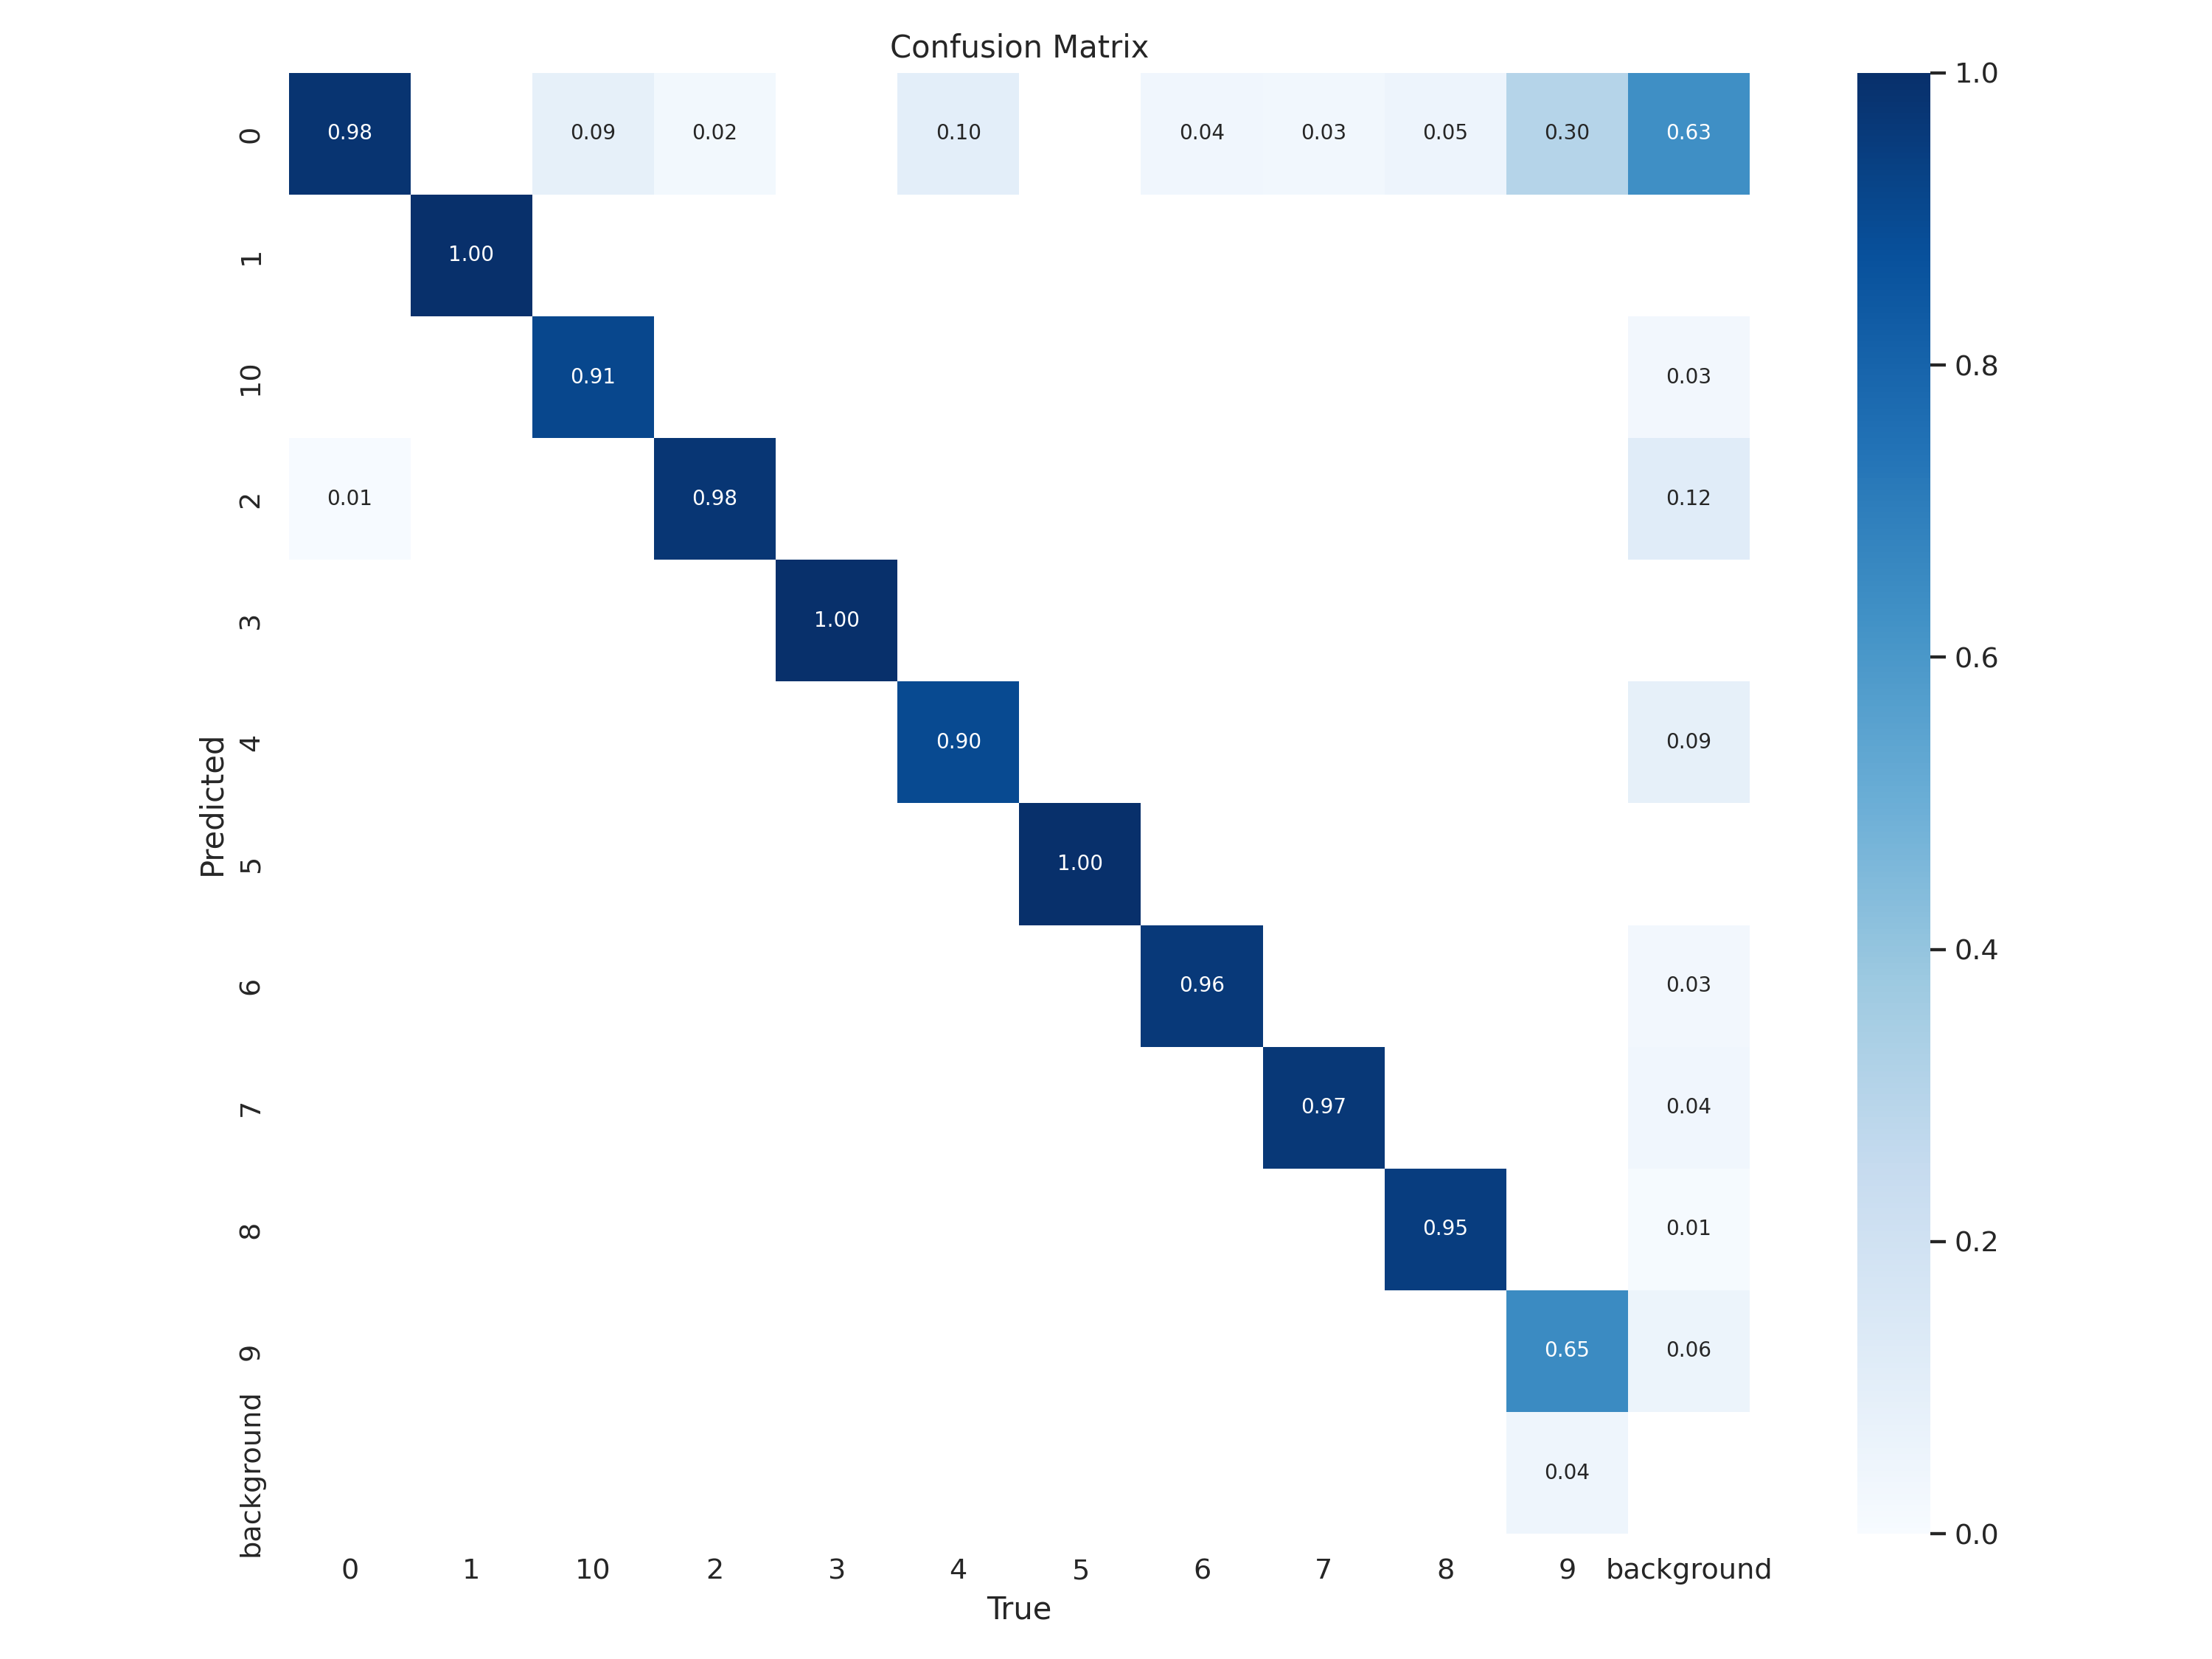

In [12]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/confusion_matrix.png', width=600)

/content


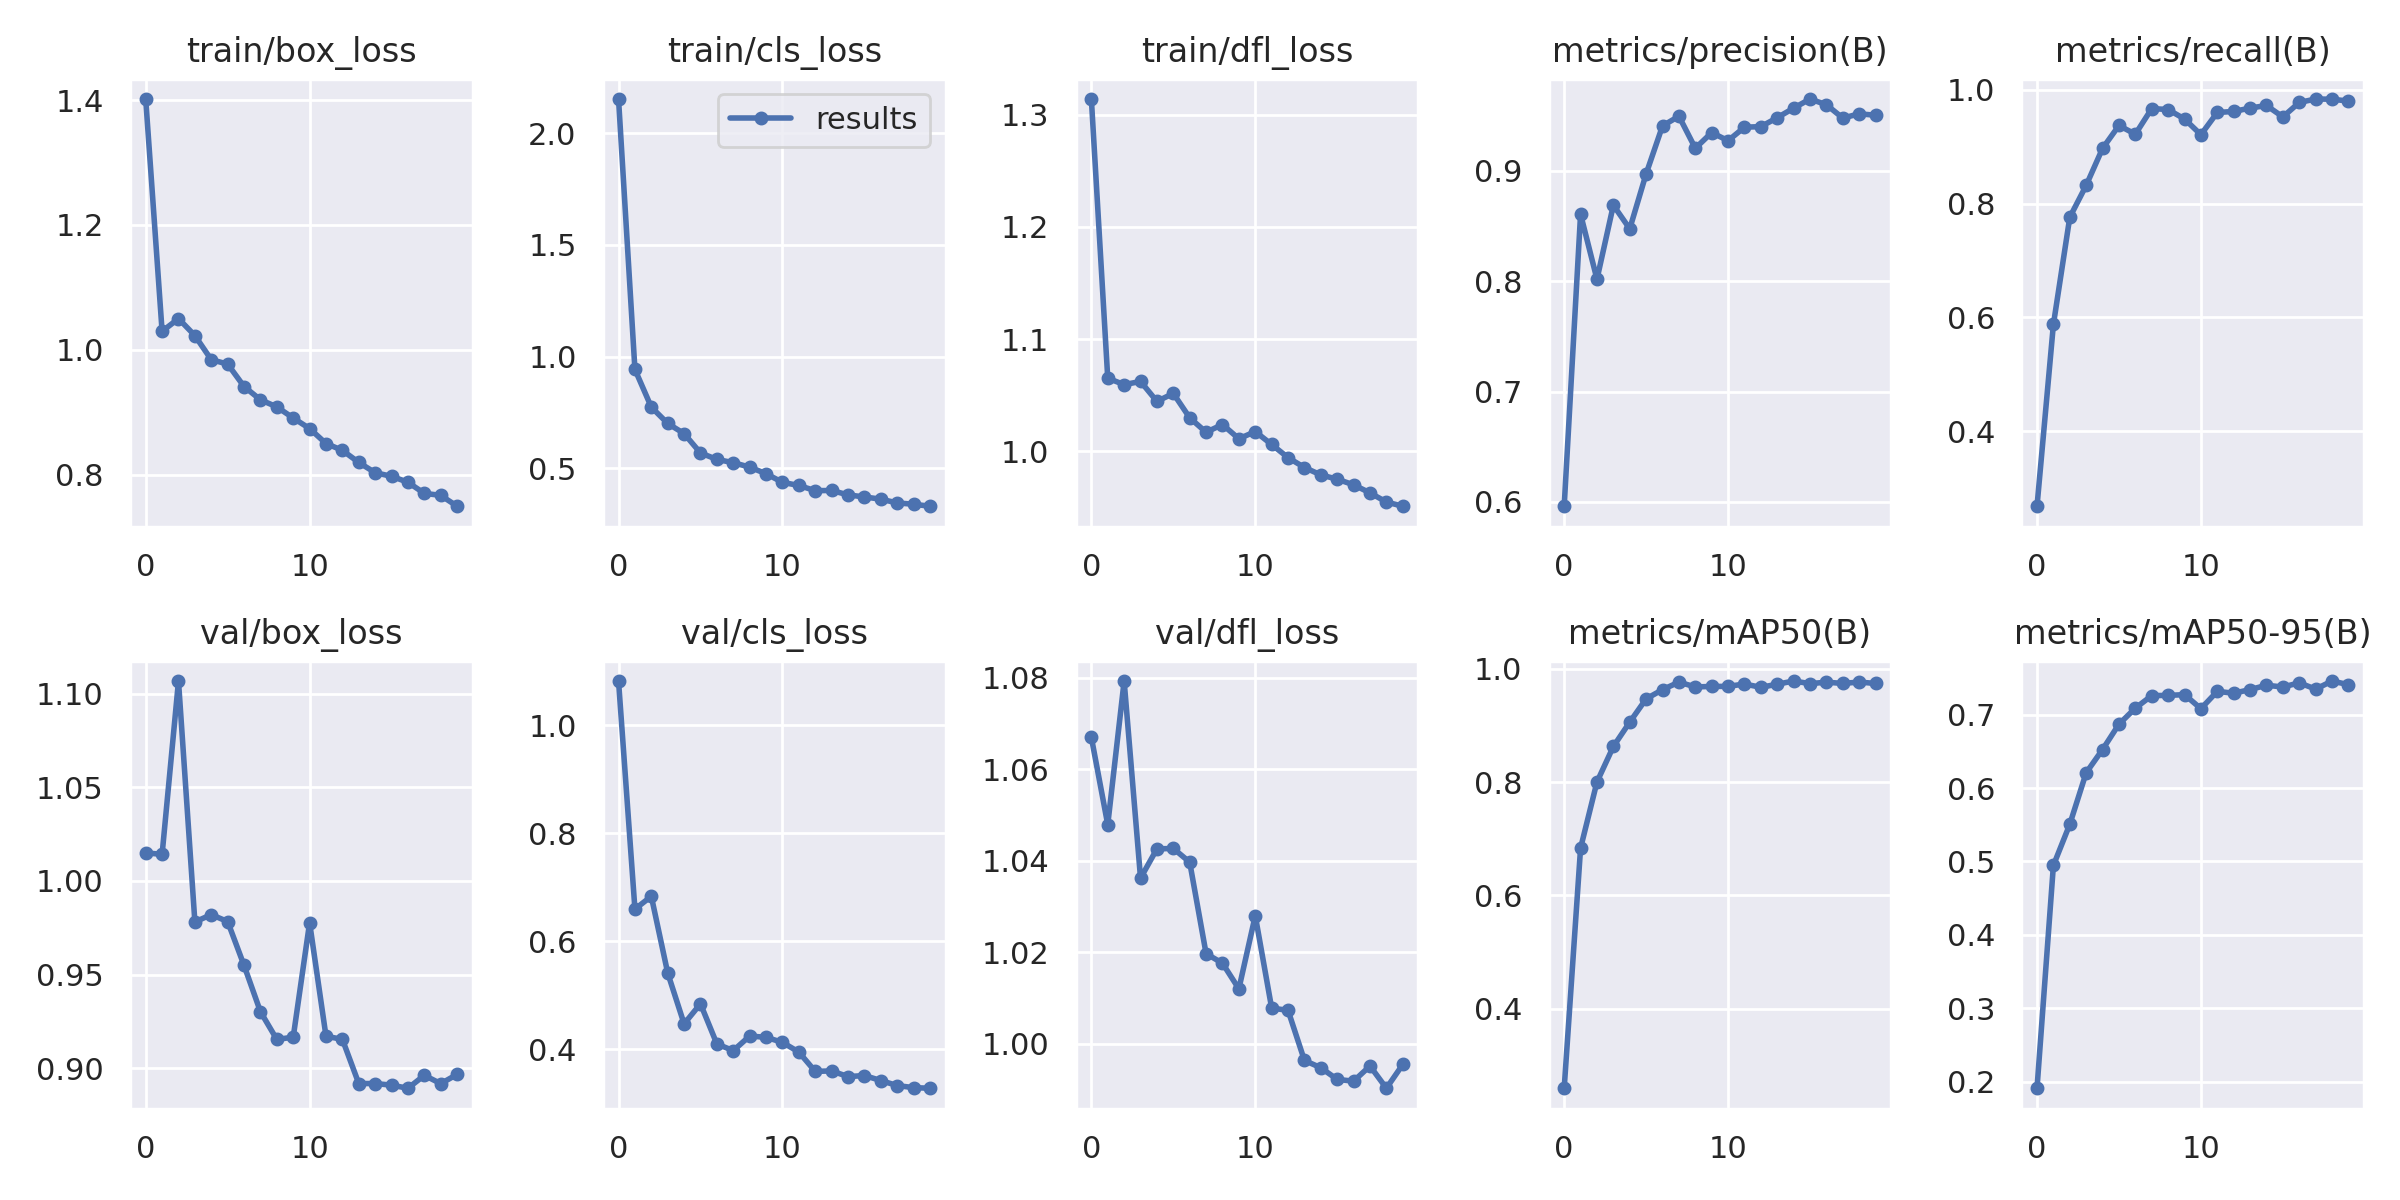

In [13]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/results.png', width=600)

/content


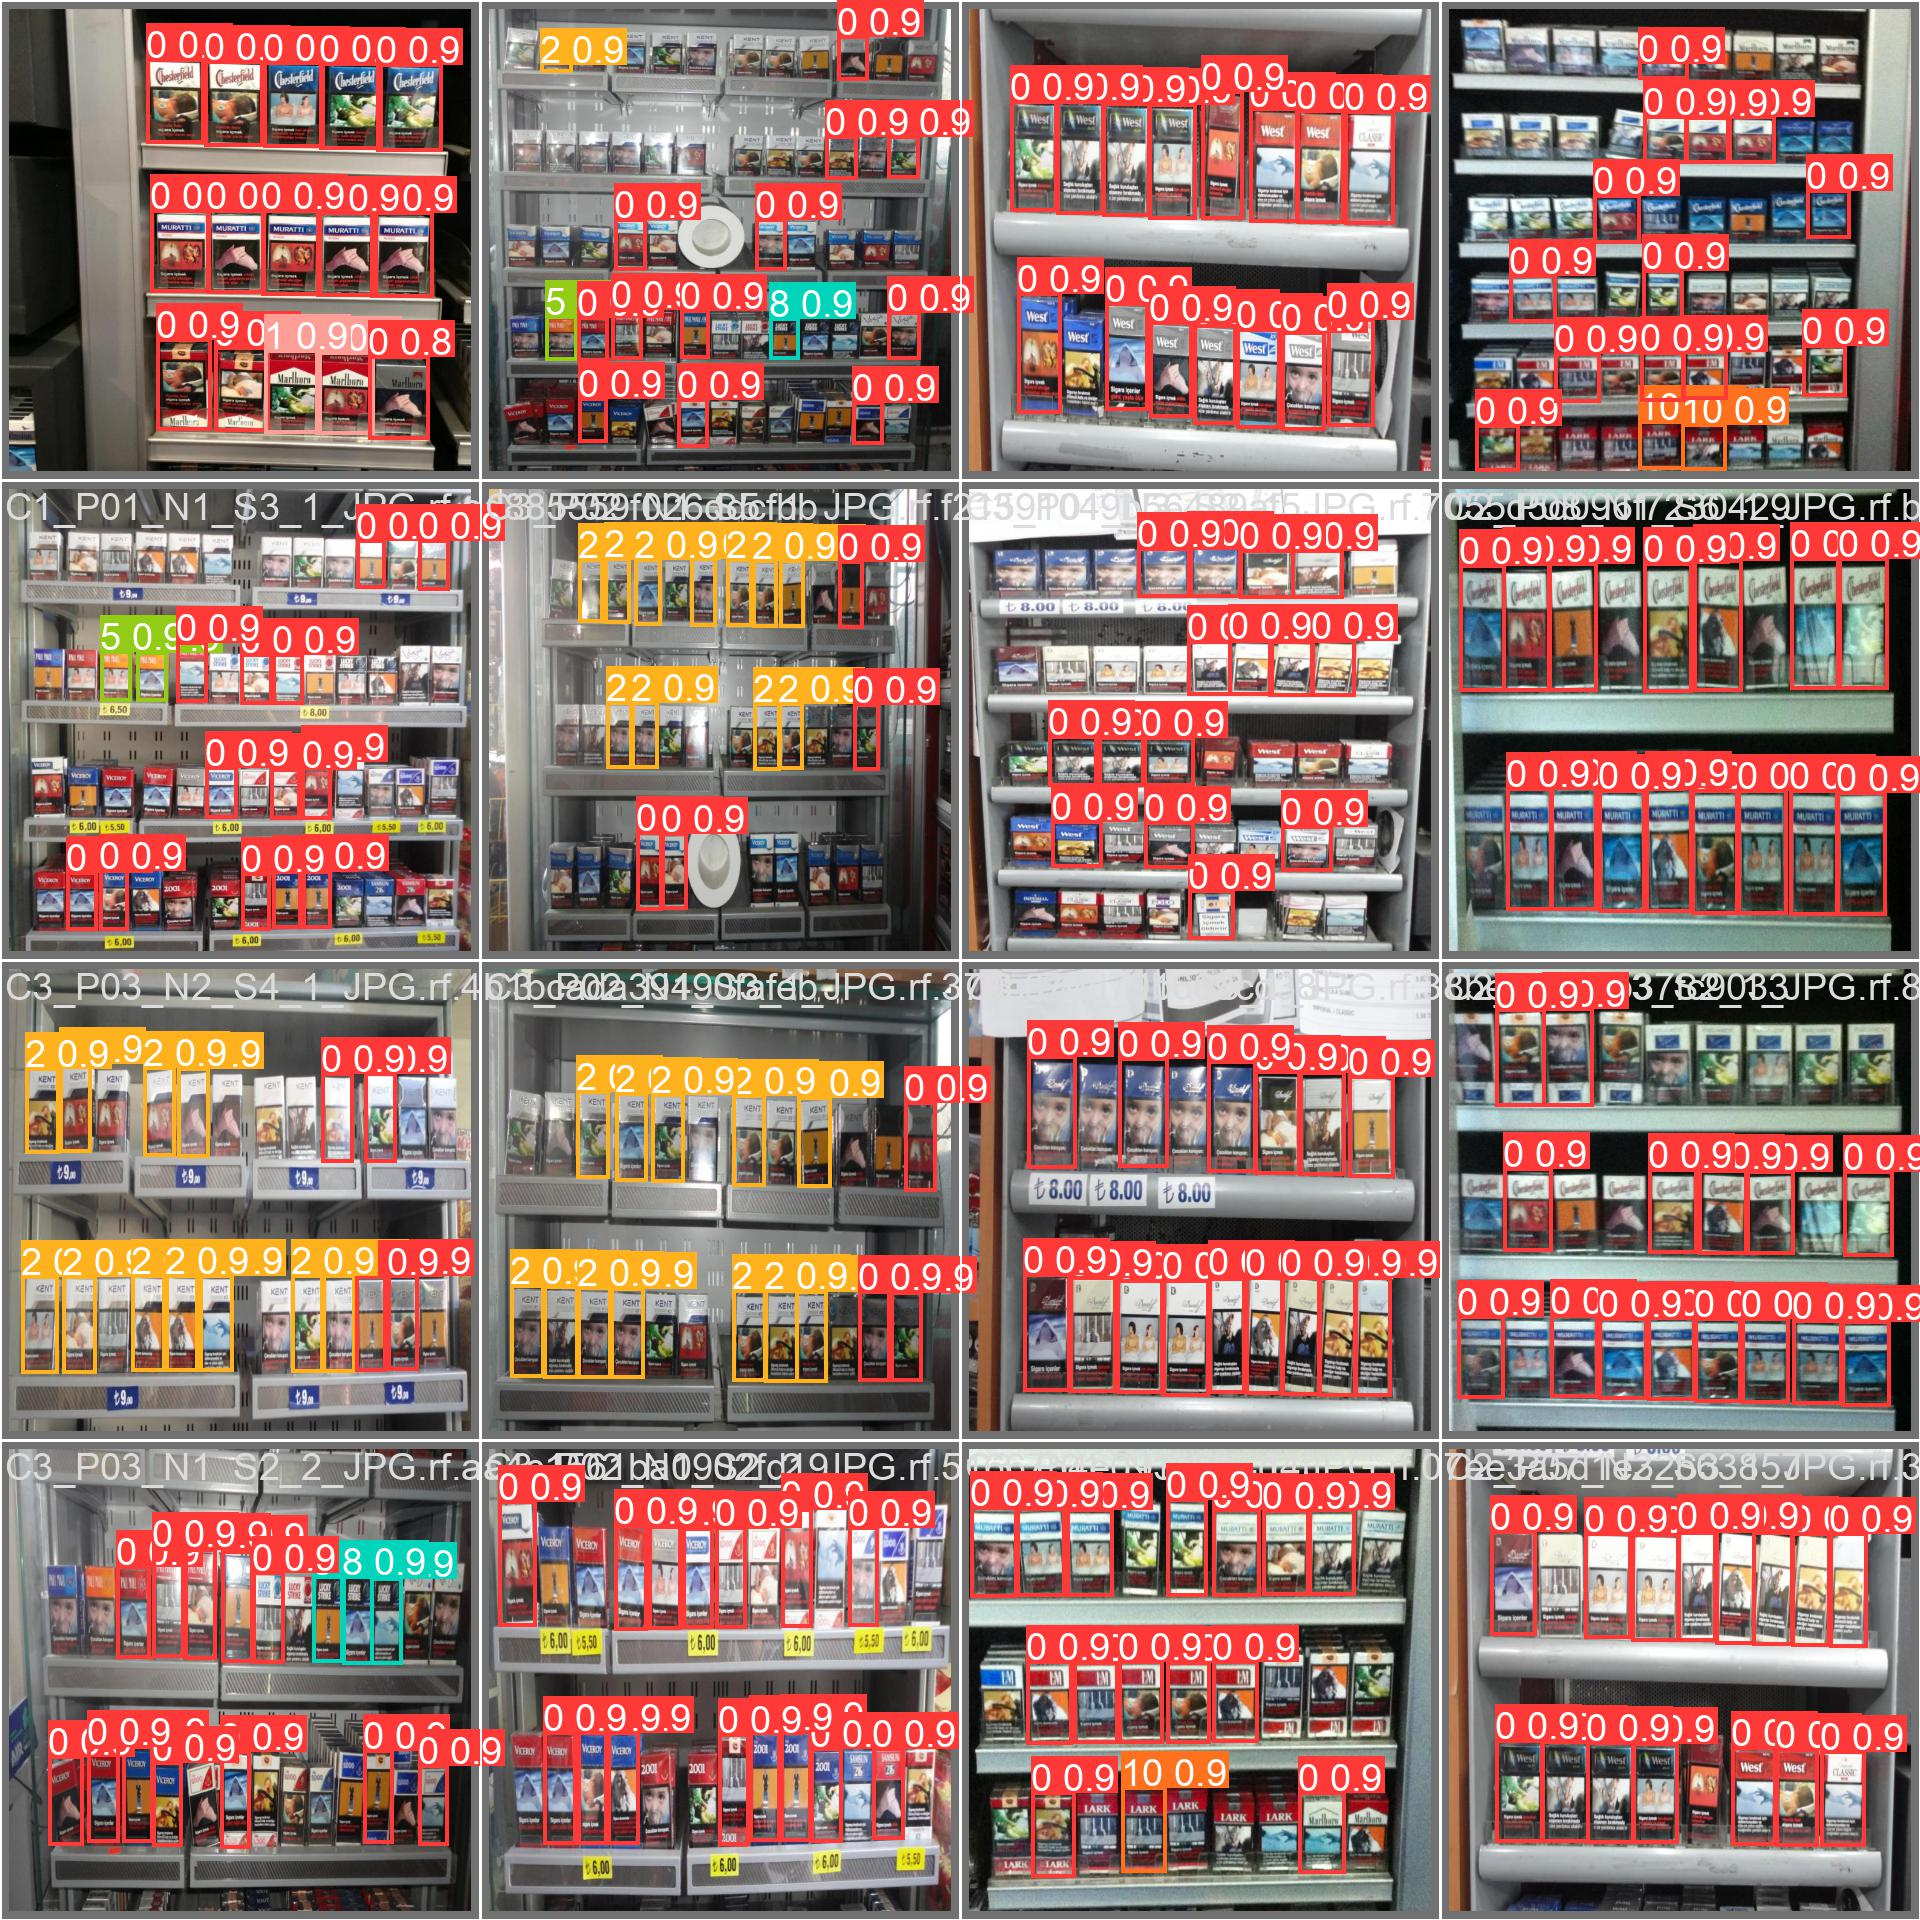

In [14]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/val_batch0_pred.jpg', width=600)

In [15]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train3/weights/best.pt data={dataset.location}/data.yaml

/content
2023-07-13 21:13:55.391615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 21:13:56.671896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11129841 parameters, 0 gradients, 28.5 GFLOPs
val: Scanning /content/groceries_detection-2/valid/labels.cache... 71 images, 0 backgrounds, 0 corrupt: 100% 71/71 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:15<00:00,  3.00s/it]
                   all         71       2733      0.952      0.983      0.977      0.745
                     0         71       21

In [16]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train3/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
2023-07-13 21:14:42.257462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 21:14:43.115375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11129841 parameters, 0 gradients, 28.5 GFLOPs
image 1/35 /content/groceries_detection-2/test/images/C1_P01_N3_S3_1_JPG.rf.b908725343de0a7973a3257ff2f82d4b.jpg: 800x800 10 0s, 2 1s, 3 4s, 24.6ms
image 2/35 /content/groceries_detection-2/test/images/C1_P02_N2_S2_1_JPG.rf.854e275a9a50fe3a1ba57fe7e615baaa.jpg: 800x800 28 0s, 24.6ms
image 3/35 /content/groceries_detection-2/test/images/C1_P02_N2_S4_1_JPG.rf.15f69ca8b4bc2c3f0f2c5048176

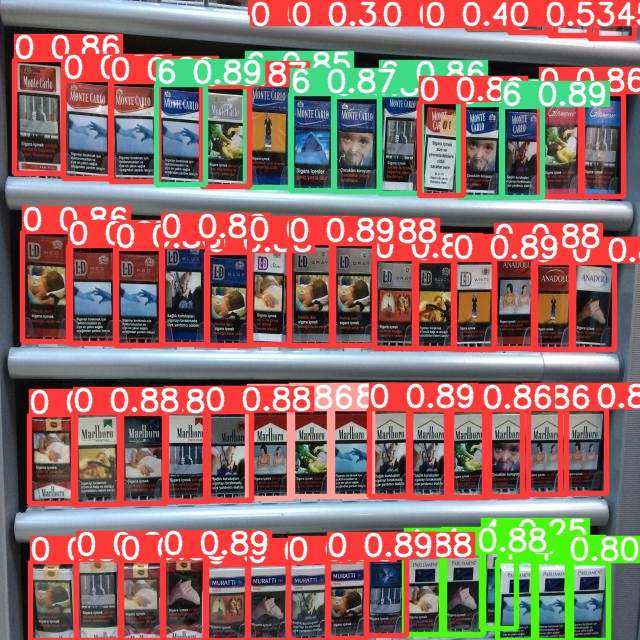

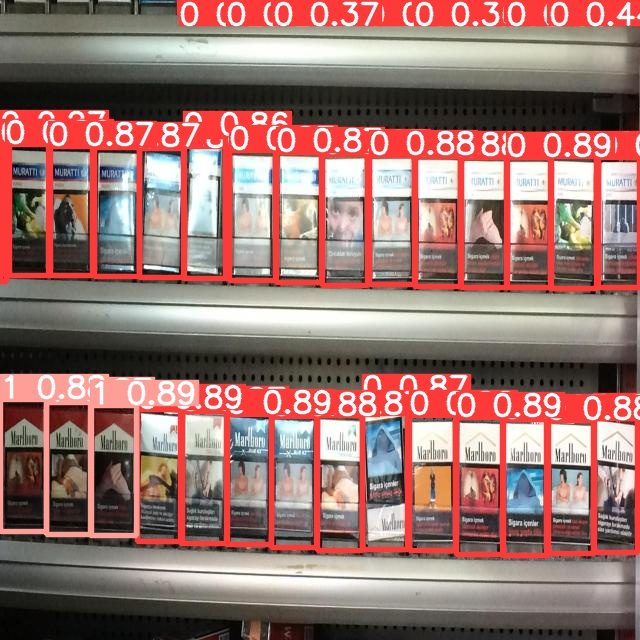

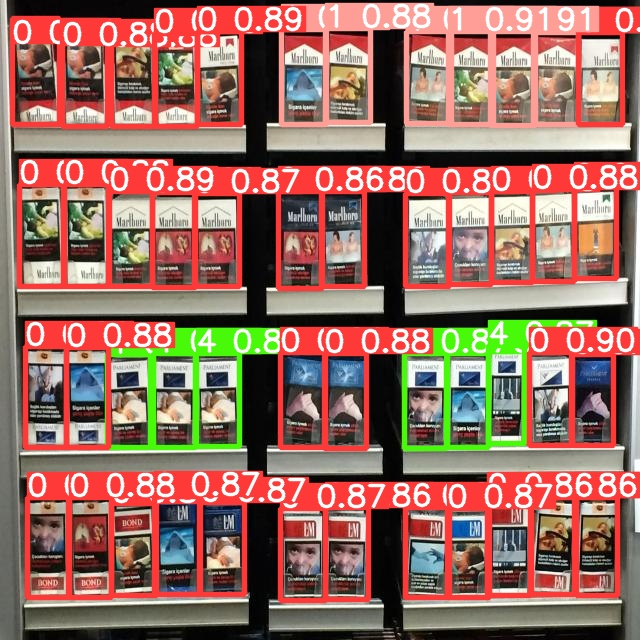

In [17]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")